#### 1.1. Import des librairies
#### 1.2. Paramètres globaux (chemins, device, classes, etc.)
#### 1.3. Réduction des masques aux 8 classes principales
#### 1.4. Définition des transformations (Albumentations)
#### 1.5. Classe `SegmentationDataset`
#### 1.6. Chargement des datasets (train / val / test)
#### 1.7. Visualisation aléatoire des images + masques


In [117]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import os

# Répertoire racine de Cityscapes
CITYSCAPES_ROOT = "../data"  # ⚠️ À adapter

# Images et masques, par split
LEFTIMG_DIR = os.path.join(CITYSCAPES_ROOT, "leftImg8bit")
MASK_DIR    = os.path.join(CITYSCAPES_ROOT, "gtFine")

# Chemins complets
TRAIN_IMG_DIR = os.path.join(LEFTIMG_DIR, "train")
VAL_IMG_DIR   = os.path.join(LEFTIMG_DIR, "val")
TEST_IMG_DIR  = os.path.join(LEFTIMG_DIR, "test")

TRAIN_MASK_DIR = os.path.join(MASK_DIR, "train")
VAL_MASK_DIR   = os.path.join(MASK_DIR, "val")
TEST_MASK_DIR  = os.path.join(MASK_DIR, "test")

# Autres paramètres globaux
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 8
IMG_SIZE = 256
BATCH_SIZE = 4


In [119]:
# Dossier racine
base_path = "../data"

# Exemple avec une image de validation
city = "frankfurt"
image_name = "frankfurt_000000_000294_leftImg8bit.png"

# Chemins
image_path = os.path.join(base_path, "leftImg8bit", "val", city, image_name)
mask_path = os.path.join(base_path, "gtFine", "val", city, image_name.replace("leftImg8bit", "gtFine_labelIds"))

# Chargement
image = Image.open(image_path)
mask = Image.open(mask_path)

# Conversion en array
image_np = np.array(image)
mask_np = np.array(mask)


In [120]:
# Mapping de l’ID des classes vers les 8 catégories principales
CITYSCAPES_8_CLASSES = {
        # flat
        7: 0, 8: 0, 9: 7, 10: 7,  # road, sidewalk, parking, rail track

        # human
        24: 1, 25: 1,  # person, rider

        # vehicle
        26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2,  # car, truck, bus, train, motorcycle, etc.

        # construction
        11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4,  # building, wall, fence, etc.

        # object
        18: 4, 19: 4, 20: 4,  # pole, traffic light/sign

        # nature
        21: 5, 22: 5,  # vegetation, terrain

        # sky
        23: 6,  # sky

        # void (tout le reste → 7)
}

def remap_mask(mask):
    """Transforme les classes Cityscapes en 8 classes cibles (valeurs 0 à 7)"""
    mask_array = np.array(mask)
    new_mask = np.zeros_like(mask_array)
    for k, v in CITYSCAPES_8_CLASSES.items():
        new_mask[mask_array == k] = v
    return new_mask


In [121]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet stats ou (0.5, 0.5, 0.5)
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [122]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = Image.open(self.mask_paths[idx])
        mask = remap_mask(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()


In [123]:
import glob
def get_cityscapes_pairs(img_root, mask_root, split="train"):
    image_paths = []
    mask_paths = []

    for city in os.listdir(img_root):
        img_files = glob.glob(os.path.join(img_root, city, "*_leftImg8bit.png"))
        for img_path in img_files:
            # Extrait le nom de fichier sans extension
            filename = os.path.basename(img_path).replace("_leftImg8bit.png", "")
            mask_path = os.path.join(mask_root, city, f"{filename}_gtFine_labelIds.png")

            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)
            else:
                print(f"❌ Masque non trouvé pour : {mask_path}")

    print(f"✅ {split} : {len(image_paths)} paires valides trouvées")
    return image_paths, mask_paths


In [124]:
train_img, train_mask = get_cityscapes_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR, "train")
val_img, val_mask = get_cityscapes_pairs(VAL_IMG_DIR, VAL_MASK_DIR, "val")


✅ train : 2975 paires valides trouvées
✅ val : 500 paires valides trouvées


In [125]:
train_dataset = SegmentationDataset(train_img, train_mask, transform=train_transform)
val_dataset = SegmentationDataset(val_img, val_mask, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [126]:
def denormalize(image_tensor, mean, std):
    """
    Dénormalise un tenseur image normalisé.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return (image_tensor * std + mean).clamp(0, 1)

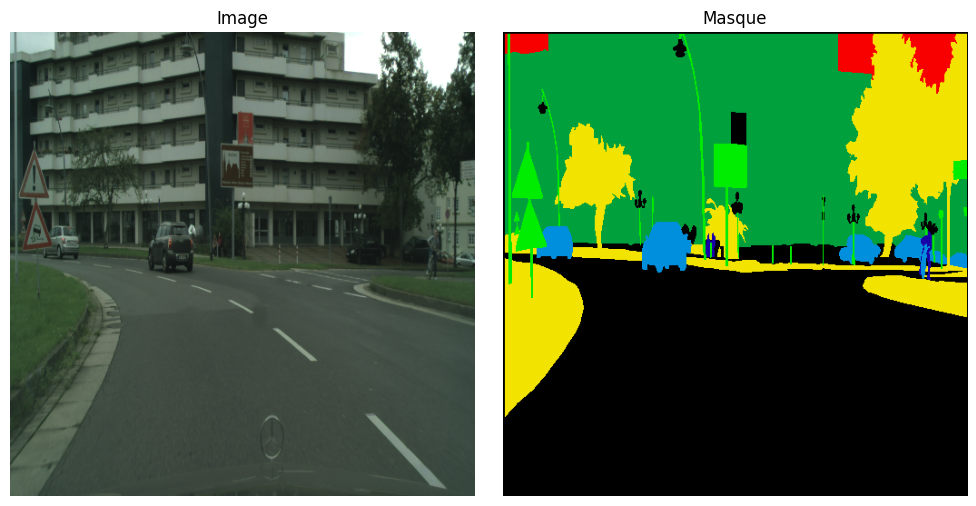

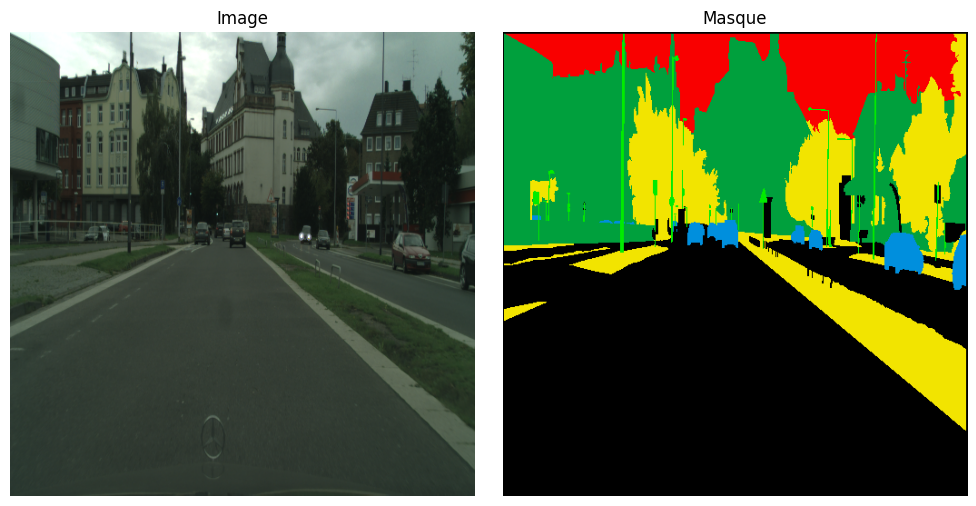

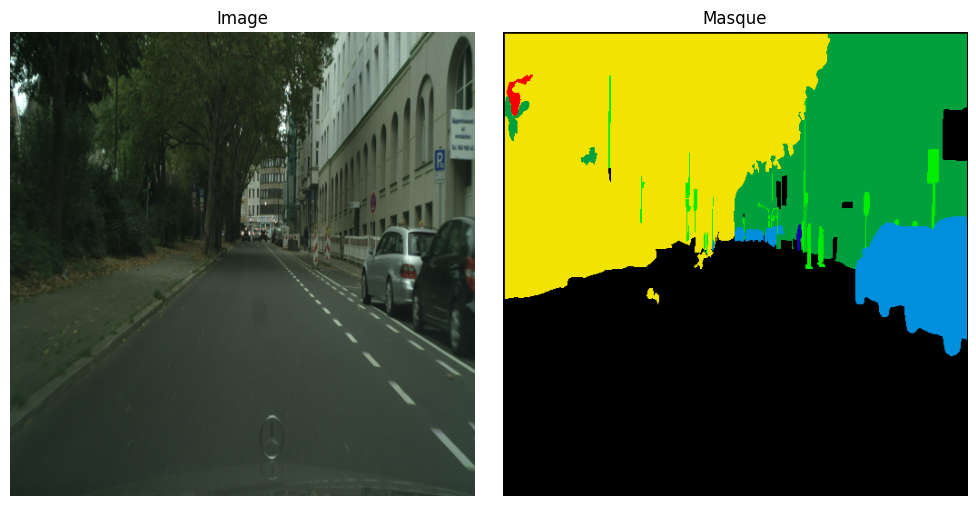

In [127]:
import matplotlib.pyplot as plt

def show_sample(dataset, n=3):
    """
    Affiche n paires (image, masque) à partir d'un dataset PyTorch.
    """

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    for i in range(n):
        image, mask = dataset[i]
        image = denormalize(image, mean, std)
        
        # Conversion pour affichage
        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()
        
        # Affichage
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image_np)
        axs[0].set_title("Image")
        axs[0].axis("off")
        
        axs[1].imshow(mask_np, cmap="nipy_spectral", vmin=0, vmax=NUM_CLASSES-1)
        axs[1].set_title("Masque")
        axs[1].axis("off")
        
        plt.tight_layout()
        plt.show()

show_sample(train_dataset)


#### 2.1. Modèle Baseline (U-Net simple ou FCN)
#### 2.2. Modèle From Scratch (U-Net complet)
#### 2.3. Modèle Transfert Learning (DeepLabV3 / U-Net + ResNet18/MobileNet)


## 2.1. Modèle Baseline (U-Net simple ou FCN)

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetBaseline(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):
        super(UNetBaseline, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)


In [129]:
model = UNetBaseline(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)


In [130]:
def compute_metrics(preds, targets, num_classes):
    preds = torch.argmax(preds, dim=1)

    ious = []
    correct_pixels = 0
    total_pixels = 0

    for cls in range(num_classes):
        pred_mask = preds == cls
        target_mask = targets == cls

        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()

        if union == 0:
            iou = float('nan')  # ignore class not present
        else:
            iou = intersection / union
            ious.append(iou)

        correct_pixels += (pred_mask == target_mask).sum().item()
        total_pixels += target_mask.numel()

    pixel_acc = correct_pixels / total_pixels
    mean_iou = np.nanmean(ious)

    return mean_iou, pixel_acc


In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


In [132]:
def evaluate_model(model, loader, loss_fn, device, num_classes):
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    n_batches = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            iou, acc = compute_metrics(outputs, masks, num_classes)
            total_iou += iou
            total_acc += acc
            n_batches += 1

    return (
        val_loss / n_batches,
        total_iou / n_batches,
        total_acc / n_batches
    )


In [133]:
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch

# 🔧 Création du modèle
model = UNetBaseline(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)

# ✅ Optimiseur
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ✅ Fonction de perte (pour classification pixel à pixel)
loss_fn = nn.CrossEntropyLoss()


In [134]:
import mlflow
import mlflow.pytorch



In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
PATIENCE = 3
PATIENCE_COUNTER = 0
EPOCHS = 10

with mlflow.start_run(run_name="UNet_baseline"):
    mlflow.log_params({
        "model": "UNetBaseline",
        "optimizer": "Adam",
        "lr": 1e-4,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model.state_dict(), "best_model.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model.pt")


2025/05/09 16:36:09 INFO mlflow.tracking.fluent: Experiment with name 'UNet_segmentation_cityscapes' does not exist. Creating a new experiment.


Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])
Image shape: torch.Size([4, 3, 512, 512])


#### 3.1. Fonction d'entraînement `train_epoch`
#### 3.2. Fonction d’évaluation `evaluate_model`
#### 3.3. Métriques de segmentation : Pixel accuracy, mIoU
#### 3.4. Sauvegarde du meilleur modèle (par IoU ou loss val)


#### 4.1. Entraînement du modèle baseline
#### 4.2. Entraînement du modèle from scratch
#### 4.3. Entraînement du modèle transfert learning
#### 4.4. Affichage des courbes de perte et métriques


#### 5.1. Comparaison des résultats (tableau résumé)
#### 5.2. Visualisation des prédictions (image + mask réel + mask prédit)
#### 5.3. Export des erreurs (images mal segmentées) en CSV


#### 6.1. Initialisation de l’expérience
#### 6.2. Logging : paramètres, métriques, modèles
#### 6.3. Logging : visualisations et artefacts


#### 7.1. Export TorchScript (`torch.jit.trace`)
#### 7.2. (Optionnel) Export ONNX
#### 7.3. Test de rechargement et prédiction à partir du modèle exporté
